In [75]:
import pandas as pd
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('stopwords')
# stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [76]:
!gdown "12SbaLA5HFfAPJOoqpDKaG4Xw8ARlBs79"

Downloading...
From: https://drive.google.com/uc?id=12SbaLA5HFfAPJOoqpDKaG4Xw8ARlBs79
To: /content/IRSE_FIRE_2022_track_train_and_test.zip
100% 946k/946k [00:00<00:00, 139MB/s]


In [77]:
!unzip "IRSE_FIRE_2022_track_train_and_test.zip"

Archive:  IRSE_FIRE_2022_track_train_and_test.zip
replace IRSE_FIRE_2022_Track_Training_Data_preprocessed.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [79]:
df = pd.read_csv("IRSE_FIRE_2022_Track_Training_Data_preprocessed.csv")

In [ ]:
df.columns

Index(['Comments', 'Surrounding Code Context', 'Class'], dtype='object')

In [82]:
print(df.shape)

(8047, 3)


In [ ]:
print("Number of missing values")
print(df.isnull().sum())

Number of missing values
Comments                    0
Surrounding Code Context    0
Class                       0
dtype: int64


In [ ]:
print("Train Target Distribution Comment Useful/Not Useful")
print(df.Class.value_counts())

Train Target Distribution Comment Useful/Not Useful
Useful        4337
Not Useful    3710
Name: Class, dtype: int64


In [ ]:
df.columns

Index(['Comments', 'Surrounding Code Context', 'Class'], dtype='object')

In [ ]:
def cleaning_dataset(df):
    
    # Pre-Processing
    # convert all questions in string format
    df['Comments'] = df['Comments'].astype(str)
    df['Surrounding Code Context'] = df['Surrounding Code Context'].astype(str)
    
    # convert all sentences in lower case
    df['Comments'] = df['Comments'].apply(lambda sentence_A: sentence_A.lower())
    df['Surrounding Code Context'] = df['Surrounding Code Context'].apply(lambda sentence_B: sentence_B.lower())
       
    return df

In [ ]:
df = cleaning_dataset(df)

In [ ]:
df.head()

,Comments,Surrounding Code Context,Class
0,/*test 529*/,-10. int res = 0;\n-9. curl *curl = null;\...,Not Useful
1,/*test 525*/,"-2. fprintf(stderr, ""usage: lib529 [url] [...",Not Useful
2,/*done*/,"-10. multi_add_handle(m, curl);\n-9. for(;...",Not Useful
3,/*test 529*/,-10. int res = 0;\n-9. curl *curl = null;\...,Not Useful
4,/*test 525*/,"-2. fprintf(stderr, ""usage: lib529 [url] [...",Not Useful


In [ ]:
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

In [ ]:
from gensim.utils import simple_preprocess

In [ ]:
df["Comments"] = df.Comments.apply(simple_preprocess)

In [ ]:
df["Surrounding Code Context"] = df["Surrounding Code Context"].apply(simple_preprocess)

In [ ]:
df.head()

,Comments,Surrounding Code Context,Class
0,[test],"[int, res, curl, curl, null, file, hd_src, nul...",0
1,[test],"[fprintf, stderr, usage, lib, url, uploadfile,...",0
2,[done],"[curl, for, struct, timeval, interval, fd_set,...",0
3,[test],"[int, res, curl, curl, null, file, hd_src, nul...",0
4,[test],"[fprintf, stderr, usage, lib, url, uploadfile,...",0


### Glove Embeddings

In [35]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-10-21 13:41:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-21 13:41:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-21 13:41:19--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [36]:
!unzip "glove.6B.zip"

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [38]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(df['Surrounding Code Context'])

In [39]:
df_code = tokenizer.texts_to_sequences(df['Surrounding Code Context'])
df_comment = tokenizer.texts_to_sequences(df['Comments'])

In [40]:
max_len = 50
df_code = pad_sequences(df_code, maxlen=max_len, padding='post')
df_comment = pad_sequences(df_comment, maxlen=max_len, padding='post')

In [41]:
print(df_code.shape,df_comment.shape)

(8047, 50) (8047, 50)


In [42]:
import numpy as np
embeddings_index = {}
f = open('/content/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [43]:
# Adding 1 because of reversed 0 index
vocab_size = len(tokenizer.word_index) + 1
print('Loaded %s word vectors.' % len(embeddings_index))

# Create a weight matrix for words in the training data
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


In [44]:
print(embedding_matrix.shape)

(11076, 100)


In [45]:
from sklearn.model_selection import train_test_split
X = np.stack((df_code, df_comment), axis=1)

In [46]:
X

array([[[   3,  104,   48, ...,    0,    0,    0],
        [  87,    0,    0, ...,    0,    0,    0]],

       [[  85,   90, 1091, ...,    0,    0,    0],
        [  87,    0,    0, ...,    0,    0,    0]],

       [[  48,   10,   25, ...,    0,    0,    0],
        [ 171,    0,    0, ...,    0,    0,    0]],

       ...,

       [[   1, 2599,    1, ...,    0,    0,    0],
        [ 174,   61,  103, ...,    0,    0,    0]],

       [[   5, 3868,  787, ...,    0,    0,    0],
        [ 787,   60,  333, ...,    0,    0,    0]],

       [[   5,   18,    5, ...,    0,    0,    0],
        [   2, 1234,  179, ...,    0,    0,    0]]], dtype=int32)

In [47]:
y = df['Class']

In [48]:
import random
data_p = list(zip(X, y))

In [49]:
random.shuffle(data_p)

In [50]:
train_data = data_p[: int(len(data_p) * 0.8)]
test_data = data_p[int(len(data_p) * 0.8):]

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [98]:
train_s1 = X_train[:,0]
train_s2 = X_train[:,1]
test_s1 = X_test[:,0]
test_s2 = X_test[:,1]

In [99]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [100]:
y_test

array([0, 0, 1, ..., 1, 1, 1])

In [105]:
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

### Siamese Model


In [106]:
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Embedding, LSTM, Lambda, concatenate, Dense, Bidirectional, Dropout, GRU, Flatten
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adagrad, Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization

In [107]:
s1_input = Input(shape=(max_len,),dtype='int32')
s2_input = Input(shape=(max_len,),dtype='int32')

input_dim, output_dim = embedding_matrix.shape
embed = Embedding(input_dim, output_dim, weights=[embedding_matrix], trainable=False)
embed_s1 = embed(s1_input)
embed_s2 = embed(s2_input)

num_dense = 50

lstm = LSTM(num_dense)

f_A = lstm(embed_s1)
f_B = lstm(embed_s2)
# lstm.layers.trainable = False

concat1 = concatenate([f_A, f_B])
# concat2 = concatenate([f_B, f_A])

sumA2B = Dense(64, activation='relu')(concat1)
sumA2B = Dense(32, activation='relu')(sumA2B)

Class = Dense(2, activation='softmax', name='entailment_AB')(sumA2B)

model = Model(inputs=[s1_input, s2_input], outputs=Class)

In [108]:
opt = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['acc'])
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 50, 100)      1107600     ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  (None, 50)           30200       ['embedding_2[0][0]',      

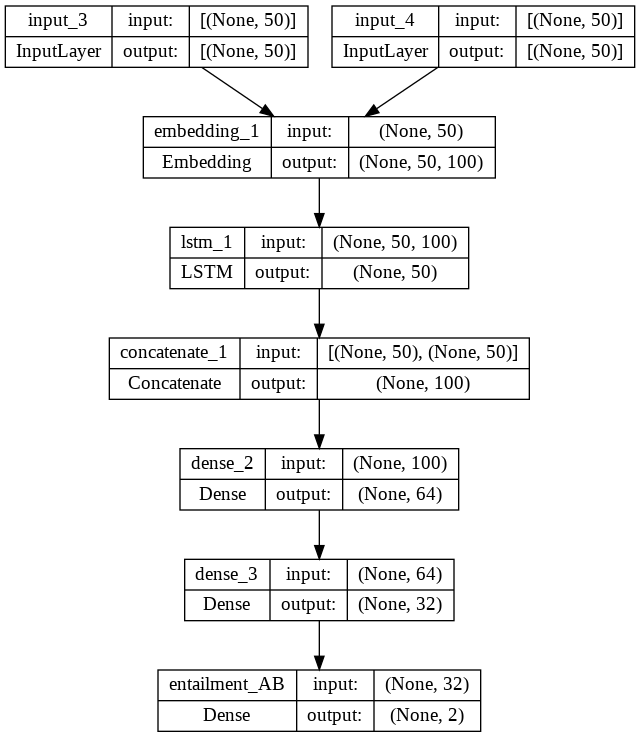

In [103]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

In [109]:
num_epochs = 20
batch_size = 32

history = model.fit(x = [train_s1, train_s2], y = y_train, epochs=num_epochs, batch_size=batch_size, verbose=1)

Epoch 1/20
176/176 [==============================] - 4s 9ms/step - loss: 0.6023 - acc: 0.6731
Epoch 2/20
176/176 [==============================] - 2s 9ms/step - loss: 0.5485 - acc: 0.7177
Epoch 3/20
176/176 [==============================] - 2s 9ms/step - loss: 0.5320 - acc: 0.7376
Epoch 4/20
176/176 [==============================] - 2s 9ms/step - loss: 0.5173 - acc: 0.7413
Epoch 5/20
176/176 [==============================] - 2s 9ms/step - loss: 0.4957 - acc: 0.7525
Epoch 6/20
176/176 [==============================] - 2s 9ms/step - loss: 0.4791 - acc: 0.7681
Epoch 7/20
176/176 [==============================] - 2s 9ms/step - loss: 0.4628 - acc: 0.7812
Epoch 8/20
176/176 [==============================] - 2s 9ms/step - loss: 0.4460 - acc: 0.7857
Epoch 9/20
176/176 [==============================] - 2s 9ms/step - loss: 0.4274 - acc: 0.7930
Epoch 10/20
176/176 [==============================] - 2s 9ms/step - loss: 0.4168 - acc: 0.8002
Epoch 11/20
176/176 [============================

In [110]:
def plotting(history):
    plt.plot(history.history['loss'])
    plt.title('LSTM Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch '+str(num_epochs))
    plt.legend(['train'], loc='upper right')
    plt.show()

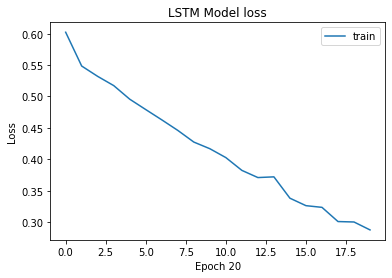

In [111]:
import matplotlib.pyplot as plt
plotting(history)

In [112]:
test = model.evaluate([test_s1, test_s2], [y_test], verbose=1)

76/76 [==============================] - 1s 6ms/step - loss: 0.7283 - acc: 0.7586


In [113]:
y_pred = model.predict([test_s1, test_s2])
yout = y_pred.argmax(axis = 1)


76/76 [==============================] - 1s 4ms/step


In [114]:
yout.shape

(2415,)

In [115]:
yout

array([0, 1, 1, ..., 0, 0, 1])

In [116]:
le.inverse_transform(yout)

array(['Not Useful', 'Useful', 'Useful', ..., 'Not Useful', 'Not Useful',
       'Useful'], dtype=object)

In [117]:
np.unique(yout,return_counts=True)

(array([0, 1]), array([1017, 1398]))

In [118]:
from sklearn.metrics import classification_report

In [119]:
# predictions = model.predict([test_s1, test_s2], batch_size=64)
print(classification_report(y_test.argmax(axis = 1), yout))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1130
           1       0.75      0.82      0.78      1285

    accuracy                           0.76      2415
   macro avg       0.76      0.75      0.76      2415
weighted avg       0.76      0.76      0.76      2415



In [120]:

from sklearn import metrics


In [127]:
y_test = y_test.argmax(axis = 1)

In [128]:
y_test

array([0, 0, 1, ..., 1, 1, 1])

In [131]:


confusion_matrix = metrics.confusion_matrix(y_test, yout)



cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Not Useful", "Useful"])



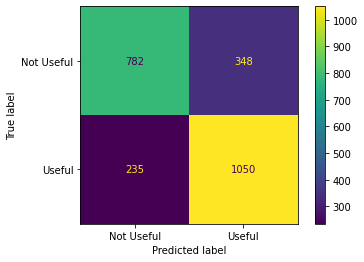

In [132]:
cm_display.plot()
plt.show() 

In [152]:
test_set = df[int(len(data_p) * 0.7):]

In [155]:
test_set[y_test!=yout]

,Comments,Surrounding Code Context,Class
5633,/*Left axis with text written perpendicular to...,-10. {\n-9. plform...,Useful
5639,/*Write separate exponential label if mode = 1.*/,-10. pos_mm + 0.5 * st...,Useful
5641,/*Left axis exponent.*/,-5. }\n-4. else\n-3. ...,Useful
5647,"/*Exponential, i.e. 10^-1, 10^0, 10^1, etc*/",-10. // These are the functions which are used...,Useful
5650,/*--------------------------------------------...,-10. static void\n-9. label_box( PLCHAR_VECTOR...,Useful
...,...,...,...
8038,/*note that the FETools::get_fe_by_name functi...,-10. Point<dim> point;\n-9. for (unsigned ...,Useful
8039,/*Decode the support points in one coordinate ...,-8. std::ostringstream namebuf;\...,Useful
8043,/*vertex/line/face domination\n(if fe_other is...,-1. return FiniteElementDomination::no_r...,Useful
8044,/*there are no requirements between continuous...,-2. if (codim > 0)\n-1. if (dynamic_cast...,Useful


In [156]:
test_set["Prediction"] = le.inverse_transform(yout)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [158]:
test_set[test_set["Class"]!=test_set['Prediction']]

,Comments,Surrounding Code Context,Class,Prediction
5632,/*Use the smallest space between ticks*/,-3. x_spacing = vpwxma - vpwxmi;\n-2. ...,Useful,Not Useful
5636,/*Right axis with text written perpendicular t...,-10. else\n-9. ...,Useful,Not Useful
5638,/*Right axis with text written parallel to edg...,-10. plsc->boxbb_ymax ...,Useful,Not Useful
5639,/*Write separate exponential label if mode = 1.*/,-10. pos_mm + 0.5 * st...,Useful,Not Useful
5643,/*Extra space for superscript*/,-4. if ( lmy )\n-3. {\...,Useful,Not Useful
...,...,...,...,...
8040,/*Do not consider the discontinuous node for d...,-10. {\n-9. if (index == 0)\...,Useful,Not Useful
8041,/*We don't need the discontinuous function for...,-10. ExcDimensionMismatch(nodal_dofs....,Useful,Not Useful
8042,/*we need an additional DG0-node for a dim-dim...,-10. riaf.back() = true;\n-9. return riaf;...,Useful,Not Useful
8044,/*there are no requirements between continuous...,-2. if (codim > 0)\n-1. if (dynamic_cast...,Useful,Not Useful
